In [309]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
from rBergomi import rBergomi
import matplotlib.pyplot as plt
import numpy as np

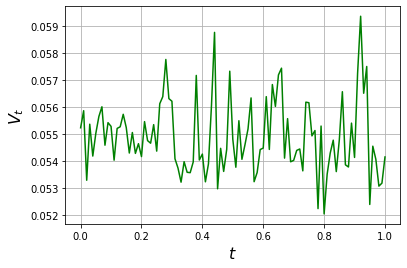

In [347]:
model = rBergomi(nsteps=100,npaths=30000, hybrid=False)
V = model.sim_V()
vV = np.var(V, axis=0, keepdims=True) 
mV = np.mean(V, axis=0, keepdims=True)
t = np.linspace(0,1,101)

plot, axes = plt.subplots()
axes.plot(t, mV[0,:], 'g')

axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$V_t$', fontsize=16)
plt.grid(True)